In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from NumpyNN.NN_np import (
    FullyConnectedLayer,
    ReLULayer,
    SigmoidLayer,
    ReLULayer,
    AdamOptimizer,
    CrossEntropyLoss,
    LinearActivation,
    Sequential,
    Optimizer,
    SoftMaxLayer,
    GradientDescentOptimizer
)

In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
def one_hot(y: np.ndarray, n_classes: int):
    encoded = np.zeros((y.size, n_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

In [4]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [5]:
y_train.shape, X_train.shape

((60000, 10), (60000, 784))

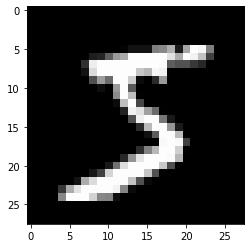

In [6]:
plt.imshow(X_train[0].reshape(28, 28))

In [7]:
mean_trainable_layers = []

def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int):

    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in range(0, X_train.shape[0], batch_size):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model.forward(X_b_train)
            loss_val = loss.forward(y_pred, y_b_train)
            loss_gradient = loss.backward()
            model.backward(loss_gradient)
            optimizer.step()

            y_pred_label = np.argmax(y_pred, axis=1)
            y_true_label = np.argmax(y_b_train, axis=1)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label))
            history['train']['loss'].append(loss_val)
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro'))

            wd = [
                np.mean([np.mean(layer.weights) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights) for layer in model.trainable_layers]),
                np.mean([np.mean(layer.weights_gradient) for layer in model.trainable_layers]),
                np.max([np.max(layer.weights_gradient) for layer in model.trainable_layers])
            ]
            weights_data.append(wd)

            uniq_gradient_vals = list(set(abs(model.trainable_layers[1].weights_gradient.flatten())))
            mean_trainable_layers.append(np.mean(a))

    return history

In [8]:
# train(model, X, y, optimizer, loss, 10, X.shape[-1])

In [9]:
model = Sequential([28*28, 100, 10], [SigmoidLayer, SoftMaxLayer])
optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 0.001)
loss = CrossEntropyLoss()

batch_size = 1024
epochs = 10
weights_data = []

history = train(model, X_train, y_train, X_test, y_test, optimizer, loss, epochs, batch_size)

In [10]:
history['train']['loss']

[2.3085026185809534,
 14.097948251491252,
 16.495863517777657,
 16.675752978167814,
 16.74770876232388,
 16.38792984154356,
 16.35195194946553,
 16.459885625699627,
 16.53184140985569,
 16.423907733621594,
 16.36994089550455,
 16.675752978167818,
 16.56781930193372,
 16.58580824797274,
 16.711730870245848,
 16.549830355894706,
 16.35195194946553,
 16.549830355894706,
 16.675752978167818,
 16.315974057387496,
 16.603797194011754,
 16.226029327192418,
 16.74770876232388,
 16.80167560044093,
 16.513852463816676,
 16.17206248907537,
 16.53184140985569,
 16.7656977083629,
 16.675752978167818,
 16.369940895504545,
 16.44189667966061,
 16.56781930193372,
 16.693741924206833,
 16.423907733621594,
 16.44189667966061,
 16.7656977083629,
 16.675752978167814,
 16.83765349251896,
 16.3159740573875,
 16.36994089550455,
 16.74770876232388,
 16.44189667966061,
 16.56781930193372,
 16.44189667966061,
 16.62178614005077,
 16.53184140985569,
 16.62178614005077,
 16.53184140985569,
 16.423907733621594,
 1

In [11]:
a = list(set(abs(model.trainable_layers[1].weights_gradient.flatten())))
np.mean(a)

5455555562.0

In [12]:
np.abs(model.trainable_layers[0].weights_gradient.flatten()).mean()

0.0

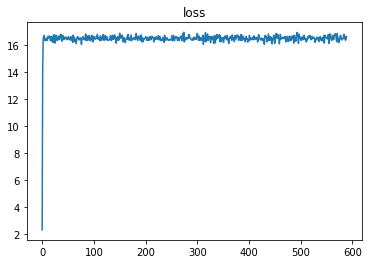

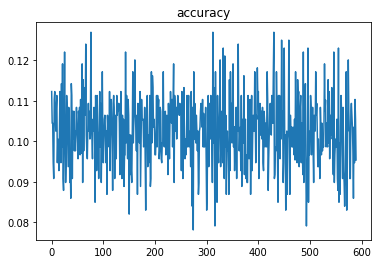

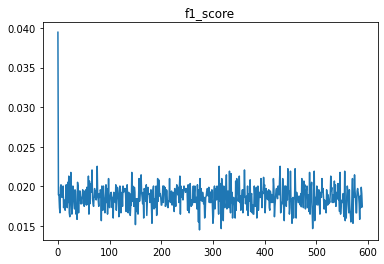

In [13]:
for key, value in history['train'].items():
    plt.plot(value)
    plt.title(key)
    plt.show()

In [14]:
a = model.forward(X_train[0])
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [15]:
"""
def train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):
    for epoch in range(epochs):
        for X_batch, y_batch in get_batches(X, y, batch_size):
            y_pred = model.forward(X_batch)
            loss_gradient = loss.gradient(y_batch, y_pred)
            model.backward(loss_gradient)
            optimizer.step()
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")
"""

'\ndef train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):\n    for epoch in range(epochs):\n        for X_batch, y_batch in get_batches(X, y, batch_size):\n            y_pred = model.forward(X_batch)\n            loss_gradient = loss.gradient(y_batch, y_pred)\n            model.backward(loss_gradient)\n            optimizer.step()\n        if verbose:\n            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")\n'

In [16]:
import torch

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:


X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train)

X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test)

def train_torch(model, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor,
          optimizer, loss, epochs: int, batch_size: int):
    
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in range(0, X_train.shape[0], batch_size):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model(X_b_train)
            loss_val = loss(y_pred, y_b_train)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            y_pred_label = np.argmax(y_pred.detach().numpy(), axis=1)
            y_true_label = np.argmax(y_b_train.detach().numpy(), axis=1)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label).item())
            history['train']['loss'].append(loss_val.item())
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro').item())

    return history

In [18]:
np.argmax([[1, 2, 3], [4, 5, 6]], axis = 0)

array([1, 1, 1], dtype=int64)

In [19]:
X_train_torch.dtype

torch.float32

In [20]:
model_torch = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10),
    torch.nn.Softmax(dim = 1)
)

weights_data_torch = []

optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=1e-3)

loss_torch = torch.nn.CrossEntropyLoss()

history_torch = train_torch(model_torch, X_train_torch, y_train_torch, X_test_torch, y_test_torch, optimizer_torch, loss_torch, 10, 4096)

In [21]:
# list(model_torch.parameters())

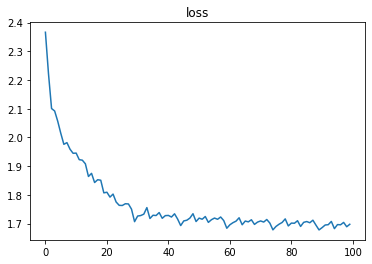

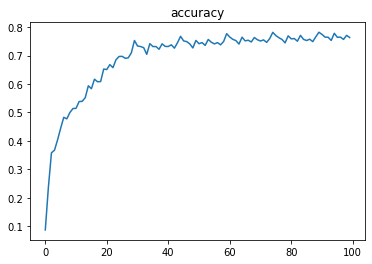

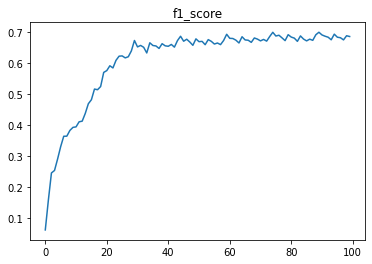

In [22]:
for key, value in history_torch['train'].items():
    plt.plot(value[:100])
    plt.title(key)
    plt.show()

In [23]:
history_torch['train']['loss'][0]

2.3664378443791065

In [24]:
import torch
torch.use_deterministic_algorithms(True)

batch_size = 10

my_fc = FullyConnectedLayer(28*28, 100)
torch_fc = torch.nn.Linear(28*28, 100)
print(my_fc.weights.shape, torch_fc.weight.shape, my_fc.bias.shape, torch_fc.bias.shape)
my_fc.weights = torch_fc.weight.detach().numpy().T
my_fc.bias = torch_fc.bias.detach().numpy().reshape(-1, 1).T

my_out = my_fc.forward(X_train[0: batch_size].reshape(batch_size, -1))
torch_out = torch_fc(torch.from_numpy(X_train[0: batch_size]).float())
torch_out_np = torch_out.detach().numpy()

print(np.allclose(my_out, torch_out_np))
print(np.abs(my_out - torch_out_np).sum())

t_s = torch.sum(torch_out)
t_s.backward()

print(torch_fc.weight.grad)



print(my_fc.input_.shape)
my_in_g = my_fc.backward(my_out)

my_wg = my_fc.weights_gradient
torch_wg = torch_fc.weight.grad.detach().numpy().T
gradien_close = np.allclose(my_wg, torch_wg)

wg_diff = np.abs(my_wg - torch_wg)
print(wg_diff.sum())

print(gradien_close)

(784, 100) torch.Size([100, 784]) (1, 100) torch.Size([100])
False
0.005880244
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
(10, 784)
620093600.0
False


In [25]:
torch_wg1 = torch_fc.weight.grad.detach().numpy().T

In [26]:
torch_wg.mean()

298.85715

In [27]:
my_wg.mean()

768.76776

In [28]:
my_fc.weights.shape

(784, 100)

In [29]:
torch_fc.weight.shape

torch.Size([100, 784])

In [30]:
torch_fc.weight

Parameter containing:
tensor([[-0.0073, -0.0264,  0.0349,  ...,  0.0314,  0.0117, -0.0345],
        [ 0.0069,  0.0036,  0.0178,  ...,  0.0102,  0.0111,  0.0111],
        [-0.0014,  0.0140, -0.0118,  ...,  0.0354, -0.0013, -0.0144],
        ...,
        [-0.0163,  0.0274,  0.0268,  ...,  0.0250, -0.0295, -0.0105],
        [-0.0278, -0.0094,  0.0080,  ...,  0.0145, -0.0141,  0.0357],
        [-0.0060, -0.0035,  0.0265,  ...,  0.0074,  0.0150,  0.0225]],
       requires_grad=True)

In [31]:
torch_fc = torch.nn.Linear(28*28, 100)
torch_fc(X_train_torch[0])



tensor([ 104.5143,   78.8784, -102.6199,  -99.9646,  -94.2891,  -48.4189,
          -1.9713,   22.6838,  -72.7144,  -36.4055,   20.2384,   35.3772,
          10.9926,  -36.4755,   29.9517,  -30.7574,   44.8759,  -39.3488,
          55.2146,  -22.4634,   46.3063,   63.7609,  -20.8011,  -27.8343,
         -74.7733,  -12.9746,  -80.6986,  -33.7447,   58.2710,  -62.3799,
         -42.7273,  -32.5890,   16.5239,  -95.7252,   -3.4959,    1.1029,
          25.7148,   -8.5825,   88.6211,    8.0188,  -22.0131,  -29.0287,
         -67.6176,   23.6517,   22.8029,  -51.2508,  -83.4126,  -14.6543,
         -88.2074,   32.4986,   55.8348,   48.8746,   12.3014,   -2.5220,
          40.2459,  -15.7658,  -57.9999,   32.1756,    8.4456,  -10.1059,
          65.2811,  -29.8653,  -32.4102,   78.8573,   28.4448,  -11.8263,
          36.3965,   74.1591,  -72.1625,   30.2102,   46.4341,   38.5306,
         -33.9602,   39.2469,   64.4754,   -1.7806, -105.6656,   72.0015,
           2.7908,  -82.2083,   19.353

In [32]:
np.sum([[1,2,3], [4,5,6]], axis  =1)

array([ 6, 15])